# Estimate polarization from raytracing and compare to reco pol

#### Reco pol is now done by using the same window for both hpol and vpol

### Mar 3, 2021

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
# import ROOT
import math
import numpy as np
# from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
# from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
# import deDisperse_util as util
# from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")
# import pyrex.custom.ara as ara


In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")

In [3]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def rotatePolVector(launchVecSrc, recVec, PolVecAntenna):
    recVec = -recVec #receiving vector needs to be reflected, otherwise rotation matrix will be off by pi
    newPol = np.dot(PolVecAntenna,rotation_matrix_from_vectors(launchVecSrc,recVec))
    return newPol

def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, np.cos(theta),-np.sin(theta)],
                   [ 0, np.sin(theta), np.cos(theta)]])

#### From Dave Besson, the cross pol is of about 25%, and it's due to the transmitter beam pattern.

## Expected polarization 

In [40]:
def estimatePolRayTracer(depth):
    #Take depth of pulser and calculate polarization rotation based on raytracer results.
    rt = pyrex.RayTracer(from_point=(0, 0, -depth), to_point=(2400, 0, -179.93)) #Use the depth of the transmitter as the z-
    #coordinate. A2 is at a horizontal distance of 2400 m from the pulser, and at a depth of 179.93 m
    path = rt.solutions[0] #We only care about direct solutions
    rotMat = rotation_matrix_from_vectors(path.received_direction,path.emitted_direction)
    initPulserPol = np.array([0,0,1])
#     initPulserPol = np.array([np.sqrt(0.25/2),np.sqrt(0.25/2),np.sqrt(0.75)])
    rotAngle = np.pi/2-np.arccos(path.emitted_direction[2])
#     pulserPol = np.array(np.matmul(initPulserPol,Rx(rotAngle)))[0]
    rotatedPol = np.dot(initPulserPol,rotMat)
    newOmegaPol = np.degrees(np.arccos(rotatedPol[2]))
    polFinal = newOmegaPol-np.degrees(rotAngle)
    return polFinal, np.degrees(rt.solutions[0].theta0)

In [32]:
rt = pyrex.RayTracer(from_point=(0, 0, -1300), to_point=(2400, 0, -179.93))

In [33]:
path = rt.solutions[0]
path2 = rt.solutions[1]

In [34]:
90-np.degrees(rt.solutions[0].theta0)

25.22013886211323

In [35]:
theta_d=np.degrees(np.arccos(path.received_direction[2])-np.pi/2)
theta_r=np.degrees(np.arccos(path2.received_direction[2])-np.pi/2)

64.77986113788677

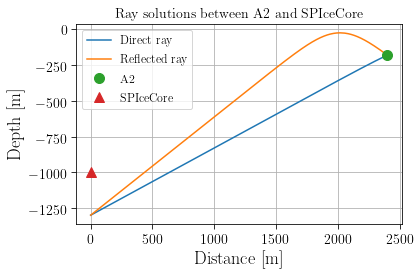

In [36]:
fig, ax1 = plt.subplots(figsize=(6,4))

# plt.plot(path.coordinates[0],path.coordinates[2], label="Direct ray ($\\theta_d =%0.1f^\circ$)"% theta_d)
# plt.plot(path2.coordinates[0],path2.coordinates[2], label="Reflected ray ($\\theta_r =%0.1f^\circ$)"% theta_r)
plt.plot(path.coordinates[0],path.coordinates[2], label="Direct ray")
plt.plot(path2.coordinates[0],path2.coordinates[2], label="Reflected ray")

plt.plot(2400, -179.93,"o", label="A2", markersize = 10)
plt.plot(0, -1000, "^", label="SPIceCore", markersize = 10)
plt.legend()
plt.ylabel("Depth [m]")
plt.xlabel("Distance [m]")
plt.grid()
plt.title("Ray solutions between A2 and SPIceCore", fontsize=14)
plt.tight_layout()
# plt.savefig(my_path_plots+'/SpiceCorePolReco/A2_SPIceCore.png', dpi=250)
np.degrees(path.theta0)
# plt.savefig(my_path_plots+'/SpiceCorePolReco/A2_SPIceCore.png', dpi=250)

In [41]:
depthArr = []
pol = []
launchAng = []
for depth in range(600,1200):
    depthArr.append(depth)
    pol.append(abs(estimatePolRayTracer(depth)[0]))
    launchAng.append((estimatePolRayTracer(depth)[1]))

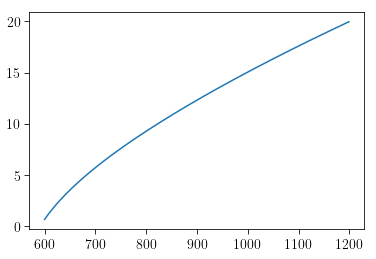

In [39]:
plt.plot(depthArr,(np.array(pol)))
# plt.xlim(600,650)

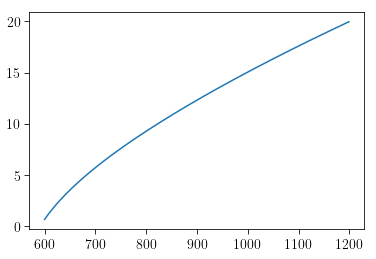

In [42]:
plt.plot(depthArr,(np.array(pol)))
# plt.xlim(600,650)

# Compare to real data

# Dec 24

In [43]:
SpiceCore0 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh0_8_run_012559.pkl")
SpiceCore0 = SpiceCore0.loc[(SpiceCore0.theta_reco>=90) & (SpiceCore0.power_H>0) & (SpiceCore0.power_V>0)]


SpiceCore1 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh1_9_run_012559.pkl")
SpiceCore1 = SpiceCore1.loc[(SpiceCore1.theta_reco>=90) & (SpiceCore1.power_H>0) & (SpiceCore1.power_V>0)]

SpiceCore2 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh2_10_run_012559.pkl")
SpiceCore2 = SpiceCore2.loc[(SpiceCore2.theta_reco>=90) & (SpiceCore2.power_H>0) & (SpiceCore2.power_V>0)]

SpiceCore3 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh3_11_run_012559.pkl")
SpiceCore3 = SpiceCore3.loc[(SpiceCore3.theta_reco>=90) & (SpiceCore3.power_H>0) & (SpiceCore3.power_V>0)]

SpiceCore4 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh4_12_run_012559.pkl")
SpiceCore4 = SpiceCore4.loc[(SpiceCore4.theta_reco>=90) & (SpiceCore4.power_H>0) & (SpiceCore4.power_V>0)]

SpiceCore5 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh5_13_run_012559.pkl")
SpiceCore5 = SpiceCore5.loc[(SpiceCore5.theta_reco>=90) & (SpiceCore5.power_H>0) & (SpiceCore5.power_V>0)]

SpiceCore6 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh6_14_run_012559.pkl")
SpiceCore6 = SpiceCore6.loc[(SpiceCore6.theta_reco>=90) & (SpiceCore6.power_H>0) & (SpiceCore6.power_V>0)]

In [44]:
depth_1224 = pd.read_csv("./plots/SpiceCorePolReco/A2_1224Depth.txt")
time = pd.to_datetime(depth_1224.NZ_Time)
# time = time.reindex(time)
# time = time.tz_localize('NZ').tz_convert("UTC")
time.head()
newTime = time.apply(lambda dt: dt.replace(day=24, month = 12, year = 2018))
# newTime#Still in NZ local time. Need to translate to UTC
df = pd.DataFrame(1, index=newTime, columns=['X'])
import pytz
nz = pytz.timezone('NZ')
utc = pytz.timezone('UTC')
df.index = df.index.tz_localize(nz).tz_convert(utc)
unixTimeDepth = (df.index - pd.Timestamp("1970-01-01").tz_localize(utc)) // pd.Timedelta('1s')#This is unix time 

In [45]:
f = scipy.interpolate.interp1d(unixTimeDepth, depth_1224.depth,bounds_error=False, fill_value=0.)
SpiceCore2ForInterp = SpiceCore2.loc[(SpiceCore2.unixtime>min(SpiceCore2.unixtime)) & (SpiceCore2.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore2ForInterp.unixtime)
SpiceCore2ForInterp["interp_depth"] = interp_depth

In [46]:
SpiceCore0ForInterp = SpiceCore0.loc[(SpiceCore0.unixtime>min(SpiceCore0.unixtime)) & (SpiceCore0.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore0ForInterp.unixtime)
SpiceCore0ForInterp["interp_depth"] = interp_depth

SpiceCore1ForInterp = SpiceCore1.loc[(SpiceCore1.unixtime>min(SpiceCore1.unixtime)) & (SpiceCore1.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore1ForInterp.unixtime)
SpiceCore1ForInterp["interp_depth"] = interp_depth

SpiceCore2ForInterp = SpiceCore2.loc[(SpiceCore2.unixtime>min(SpiceCore2.unixtime)) & (SpiceCore2.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore2ForInterp.unixtime)
SpiceCore2ForInterp["interp_depth"] = interp_depth

SpiceCore3ForInterp = SpiceCore3.loc[(SpiceCore3.unixtime>min(SpiceCore3.unixtime)) & (SpiceCore3.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore3ForInterp.unixtime)
SpiceCore3ForInterp["interp_depth"] = interp_depth

SpiceCore4ForInterp = SpiceCore4.loc[(SpiceCore4.unixtime>min(SpiceCore4.unixtime)) & (SpiceCore4.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore4ForInterp.unixtime)
SpiceCore4ForInterp["interp_depth"] = interp_depth

SpiceCore5ForInterp = SpiceCore5.loc[(SpiceCore5.unixtime>min(SpiceCore5.unixtime)) & (SpiceCore5.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore5ForInterp.unixtime)
SpiceCore5ForInterp["interp_depth"] = interp_depth

SpiceCore6ForInterp = SpiceCore6.loc[(SpiceCore6.unixtime>min(SpiceCore6.unixtime)) & (SpiceCore6.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore6ForInterp.unixtime)
SpiceCore6ForInterp["interp_depth"] = interp_depth

In [47]:
X_pol = 0.1#Fraction of crosspol

In [1]:
SpiceCore0ForInterp["R"] = np.sqrt((SpiceCore0ForInterp.power_H-SpiceCore0ForInterp.powerH_noise)/(SpiceCore0ForInterp.power_V-SpiceCore0ForInterp.powerV_noise))
SpiceCore0ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore0ForInterp.theta_reco))/np.sqrt(1+SpiceCore0ForInterp.R**2)))
SpiceCore0ForInterp["R2"] = np.sqrt((SpiceCore0ForInterp.power_H-SpiceCore0ForInterp.powerH_noise)/(SpiceCore0ForInterp.power_V-SpiceCore0ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore0ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore0ForInterp.theta_reco))/np.sqrt(1+SpiceCore0ForInterp.R2**2)))

SpiceCore1ForInterp["R"] = np.sqrt((SpiceCore1ForInterp.power_H-SpiceCore1ForInterp.powerH_noise)/(SpiceCore1ForInterp.power_V-SpiceCore1ForInterp.powerV_noise))
SpiceCore1ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore1ForInterp.theta_reco))/np.sqrt(1+SpiceCore1ForInterp.R**2)))
SpiceCore1ForInterp["R2"] = np.sqrt((SpiceCore1ForInterp.power_H-SpiceCore1ForInterp.powerH_noise)/(SpiceCore1ForInterp.power_V-SpiceCore1ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore1ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore1ForInterp.theta_reco))/np.sqrt(1+SpiceCore1ForInterp.R2**2)))


SpiceCore2ForInterp["R"] = np.sqrt((SpiceCore2ForInterp.power_H-SpiceCore2ForInterp.powerH_noise)/(SpiceCore2ForInterp.power_V-SpiceCore2ForInterp.powerV_noise))
SpiceCore2ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore2ForInterp.theta_reco))/np.sqrt(1+SpiceCore2ForInterp.R**2)))
SpiceCore2ForInterp["R2"] = np.sqrt((SpiceCore2ForInterp.power_H-SpiceCore2ForInterp.powerH_noise)/(SpiceCore2ForInterp.power_V-SpiceCore2ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore2ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore2ForInterp.theta_reco))/np.sqrt(1+SpiceCore2ForInterp.R2**2)))

SpiceCore3ForInterp["R"] = np.sqrt((SpiceCore3ForInterp.power_H-SpiceCore3ForInterp.powerH_noise)/(SpiceCore3ForInterp.power_V-SpiceCore3ForInterp.powerV_noise))
SpiceCore3ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore3ForInterp.theta_reco))/np.sqrt(1+SpiceCore3ForInterp.R**2)))
SpiceCore3ForInterp["R2"] = np.sqrt((SpiceCore3ForInterp.power_H-SpiceCore3ForInterp.powerH_noise)/(SpiceCore3ForInterp.power_V-SpiceCore3ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore3ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore3ForInterp.theta_reco))/np.sqrt(1+SpiceCore3ForInterp.R2**2)))

SpiceCore4ForInterp["R"] = np.sqrt((SpiceCore4ForInterp.power_H-SpiceCore4ForInterp.powerH_noise)/(SpiceCore4ForInterp.power_V-SpiceCore4ForInterp.powerV_noise))
SpiceCore4ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore4ForInterp.theta_reco))/np.sqrt(1+SpiceCore4ForInterp.R**2)))
SpiceCore4ForInterp["R2"] = np.sqrt((SpiceCore4ForInterp.power_H-SpiceCore4ForInterp.powerH_noise)/(SpiceCore4ForInterp.power_V-SpiceCore4ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore4ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore4ForInterp.theta_reco))/np.sqrt(1+SpiceCore4ForInterp.R2**2)))

SpiceCore5ForInterp["R"] = np.sqrt((SpiceCore5ForInterp.power_H-SpiceCore5ForInterp.powerH_noise)/(SpiceCore5ForInterp.power_V-SpiceCore5ForInterp.powerV_noise))
SpiceCore5ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore5ForInterp.theta_reco))/np.sqrt(1+SpiceCore5ForInterp.R**2)))
SpiceCore5ForInterp["R2"] = np.sqrt((SpiceCore5ForInterp.power_H-SpiceCore5ForInterp.powerH_noise)/(SpiceCore5ForInterp.power_V-SpiceCore5ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore5ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore5ForInterp.theta_reco))/np.sqrt(1+SpiceCore5ForInterp.R2**2)))


SpiceCore6ForInterp["R"] = np.sqrt((SpiceCore6ForInterp.power_H-SpiceCore6ForInterp.powerH_noise)/(SpiceCore6ForInterp.power_V-SpiceCore6ForInterp.powerV_noise))
SpiceCore6ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore6ForInterp.theta_reco))/np.sqrt(1+SpiceCore6ForInterp.R**2)))
SpiceCore6ForInterp["R2"] = np.sqrt((SpiceCore6ForInterp.power_H-SpiceCore6ForInterp.powerH_noise)/(SpiceCore6ForInterp.power_V-SpiceCore6ForInterp.powerV_noise))*(1-X_pol)-X_pol
SpiceCore6ForInterp["Omega_reco3"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore6ForInterp.theta_reco))/np.sqrt(1+SpiceCore6ForInterp.R2**2)))


SpiceCore0ForInterp = SpiceCore0ForInterp.dropna()
SpiceCore1ForInterp = SpiceCore1ForInterp.dropna()
SpiceCore2ForInterp = SpiceCore2ForInterp.dropna()
SpiceCore3ForInterp = SpiceCore3ForInterp.dropna()
SpiceCore4ForInterp = SpiceCore4ForInterp.dropna()
SpiceCore5ForInterp = SpiceCore5ForInterp.dropna()
SpiceCore6ForInterp = SpiceCore6ForInterp.dropna()

NameError: name 'np' is not defined

In [49]:
debug = SpiceCore6ForInterp.loc[SpiceCore6ForInterp.EvNum == 25653]
np.degrees(np.arccos(np.sign(debug.R2)*np.sin(np.radians(debug.theta_reco))/np.sqrt(1+debug.R2**2)))-180*np.heaviside(-1*np.sign(debug.R2),1)

2572   -3.694437
dtype: float64

In [50]:
np.heaviside(np.sign(1),1)

1.0

In [51]:
# fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
# axs = ax.ravel()
# sns.regplot(x=SpiceCore0ForInterp.interp_depth, y=SpiceCore0ForInterp.Omega_reco3, x_bins=50, fit_reg=None, ax =axs[0], label = "$\Omega_{measured}$ [Ch0, Ch8]")
# sns.regplot(x=SpiceCore1ForInterp.interp_depth, y=SpiceCore1ForInterp.Omega_reco3, x_bins=50, fit_reg=None, ax =axs[1], label = "$\Omega_{measured}$ [Ch1, Ch9]")
# sns.regplot(x=SpiceCore2ForInterp.interp_depth, y=SpiceCore2ForInterp.Omega_reco3, x_bins=50, fit_reg=None, ax =axs[2], label = "$\Omega_{measured}$ [Ch2, Ch10]")
# sns.regplot(x=SpiceCore3ForInterp.interp_depth, y=SpiceCore3ForInterp.Omega_reco3, x_bins=50, fit_reg=None, ax =axs[3], label = "$\Omega_{measured}$ [Ch3, Ch11]")
# sns.regplot(x=SpiceCore4ForInterp.interp_depth, y=SpiceCore4ForInterp.Omega_reco3, x_bins=50, fit_reg=None, ax =axs[4], label = "$\Omega_{measured}$ [Ch4, Ch12]")
# sns.regplot(x=SpiceCore5ForInterp.interp_depth, y=SpiceCore5ForInterp.Omega_reco3, x_bins=50, fit_reg=None, ax =axs[5], label = "$\Omega_{measured}$ [Ch5, Ch13]")
# sns.regplot(x=SpiceCore6ForInterp.interp_depth, y=SpiceCore6ForInterp.Omega_reco3, x_bins=50, fit_reg=None, ax =axs[6], label = "$\Omega_{measured}$ [Ch6, Ch14]")

# # axs[6].set_xlabel("unixTime")
# fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20)
# fig.text(0.03, 0.5, '$\Omega_{expected}$ [deg]', ha='center', va='center', rotation='vertical', fontsize=20)

# for ax in axs:
# #     ax.set_xlabel("a")
#     ax.set_xlim(350,1200)
#     ax.set_ylim(0,40)
#     ax.set(xlabel="", ylabel = "")
#     ax.plot(depthArr,pol,"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")


#     ax.legend(loc="upper left")

# plt.suptitle("Run 012559 [Dec 24, 2018], $\chi_{pol} = %0.1f$"%X_pol, fontsize=20)
# plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
# # plt.savefig(my_path_plots+'/SpiceCorePolReco/NewSpiceCoreOmegaRecoTrueVsDepth_run012559_%0.1f.png'%X_pol, dpi=250)


## Scatter

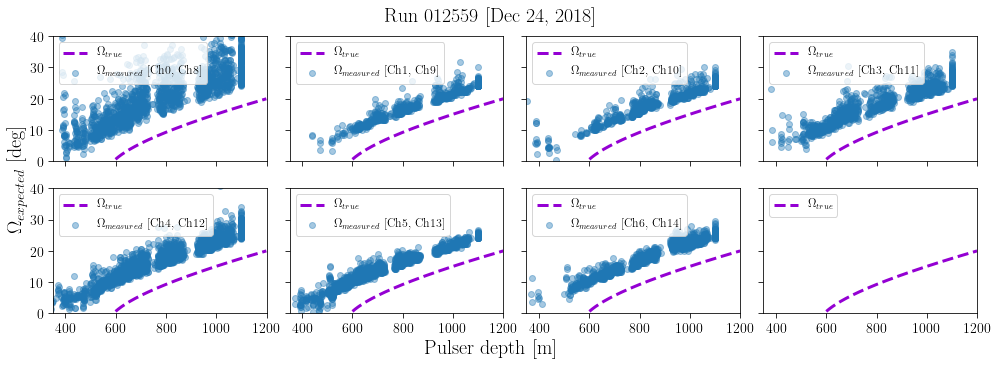

In [56]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()
axs[0].scatter(SpiceCore0ForInterp.interp_depth, SpiceCore0ForInterp.Omega_reco2, alpha = 0.4, label = "$\Omega_{measured}$ [Ch0, Ch8]")
axs[1].scatter(SpiceCore1ForInterp.interp_depth, SpiceCore1ForInterp.Omega_reco2, alpha = 0.4, label = "$\Omega_{measured}$ [Ch1, Ch9]")
axs[2].scatter(SpiceCore2ForInterp.interp_depth, SpiceCore2ForInterp.Omega_reco2, alpha = 0.4, label = "$\Omega_{measured}$ [Ch2, Ch10]")
axs[3].scatter(SpiceCore3ForInterp.interp_depth, SpiceCore3ForInterp.Omega_reco2, alpha = 0.4, label = "$\Omega_{measured}$ [Ch3, Ch11]")
axs[4].scatter(SpiceCore4ForInterp.interp_depth, SpiceCore4ForInterp.Omega_reco2, alpha = 0.4, label = "$\Omega_{measured}$ [Ch4, Ch12]")
axs[5].scatter(SpiceCore5ForInterp.interp_depth, SpiceCore5ForInterp.Omega_reco2, alpha = 0.4, label = "$\Omega_{measured}$ [Ch5, Ch13]")
axs[6].scatter(SpiceCore6ForInterp.interp_depth, SpiceCore6ForInterp.Omega_reco2, alpha = 0.4, label = "$\Omega_{measured}$ [Ch6, Ch14]")

# axs[6].set_xlabel("unixTime")
fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20)
fig.text(0.03, 0.5, '$\Omega_{expected}$ [deg]', ha='center', va='center', rotation='vertical', fontsize=20)

for ax in axs:
#     ax.set_xlabel("a")
    ax.set_xlim(350,1200)
    ax.set_ylim(0,40)
    ax.set(xlabel="", ylabel = "")
    ax.plot(depthArr,np.array(pol),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")


    ax.legend(loc="upper left")

plt.suptitle("Run 012559 [Dec 24, 2018]", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
# plt.savefig(my_path_plots+'/SpiceCorePolReco/NewSpiceCoreScatter_run012559_%0.1f.png'%X_pol, dpi=250)


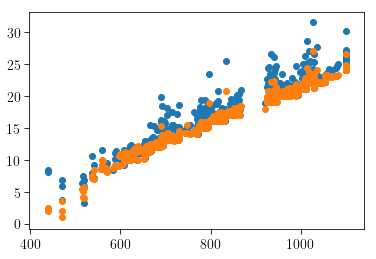

In [25]:
plt.scatter(SpiceCore1ForInterp.interp_depth, SpiceCore1ForInterp.Omega_reco2)
plt.scatter(SpiceCore1ForInterp.interp_depth, SpiceCore1ForInterp.Omega_reco3)

11.343469619312149


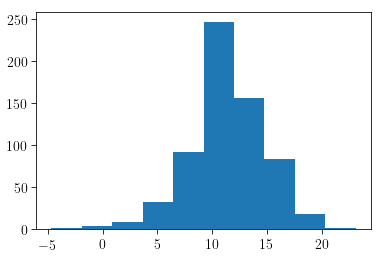

In [83]:
plt.hist(SpiceCore1ForInterp.Omega_reco3-SpiceCore1ForInterp.Omega_reco2);
diff = SpiceCore1ForInterp.Omega_reco3-SpiceCore1ForInterp.Omega_reco2
print(diff.mean())

Text(0.5,0,'$R^2$')

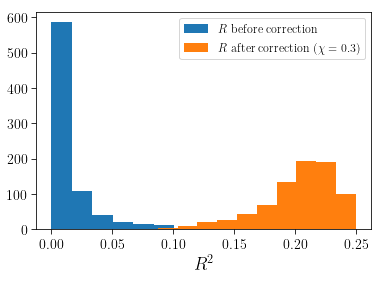

In [84]:
plt.hist(SpiceCore2ForInterp.R**2, label = "$R$ before correction");
plt.hist(SpiceCore2ForInterp.R2**2, label = "$R$ after correction ($\chi = 0.3$)");
plt.legend()
plt.xlabel("$R^2$")

## Distributions

In [154]:
# SpiceCore0ForInterp_limited = 0
SpiceCore0ForInterp_limited = SpiceCore0ForInterp.loc[(SpiceCore0ForInterp.interp_depth>600) & (SpiceCore0ForInterp.interp_depth<1000)]
SpiceCore1ForInterp_limited = SpiceCore1ForInterp.loc[(SpiceCore1ForInterp.interp_depth>600) & (SpiceCore1ForInterp.interp_depth<1000)]
SpiceCore2ForInterp_limited = SpiceCore2ForInterp.loc[(SpiceCore2ForInterp.interp_depth>600) & (SpiceCore2ForInterp.interp_depth<1000)]
SpiceCore3ForInterp_limited = SpiceCore3ForInterp.loc[(SpiceCore3ForInterp.interp_depth>600) & (SpiceCore3ForInterp.interp_depth<1000)]
SpiceCore4ForInterp_limited = SpiceCore4ForInterp.loc[(SpiceCore4ForInterp.interp_depth>600) & (SpiceCore4ForInterp.interp_depth<1000)]
SpiceCore5ForInterp_limited = SpiceCore5ForInterp.loc[(SpiceCore5ForInterp.interp_depth>600) & (SpiceCore5ForInterp.interp_depth<1000)]
SpiceCore6ForInterp_limited = SpiceCore6ForInterp.loc[(SpiceCore6ForInterp.interp_depth>600) & (SpiceCore6ForInterp.interp_depth<1000)]


In [158]:

depthArr0 = []
pol0 = []
launchAng0 = []

depthArr1 = []
pol1 = []
launchAng1 = []

depthArr2 = []
pol2 = []
launchAng2 = []

depthArr3 = []
pol3 = []
launchAng3 = []

depthArr4 = []
pol4 = []
launchAng4 = []

depthArr5 = []
pol5 = []
launchAng5 = []

depthArr6 = []
pol6 = []
launchAng6 = []

for i in SpiceCore0ForInterp_limited.itertuples():
    depthArr0.append(i.interp_depth)
    pol0.append(abs(estimatePolRayTracer(i.interp_depth)[0]))
    launchAng0.append((estimatePolRayTracer(i.interp_depth)[1]))

for i in SpiceCore1ForInterp_limited.itertuples():
    depthArr1.append(i.interp_depth)
    pol1.append(abs(estimatePolRayTracer(i.interp_depth)[0]))
    launchAng1.append((estimatePolRayTracer(i.interp_depth)[1]))

for i in SpiceCore2ForInterp_limited.itertuples():
    depthArr2.append(i.interp_depth)
    pol2.append(abs(estimatePolRayTracer(i.interp_depth)[0]))
    launchAng2.append((estimatePolRayTracer(i.interp_depth)[1]))

for i in SpiceCore3ForInterp_limited.itertuples():
    depthArr3.append(i.interp_depth)
    pol3.append(abs(estimatePolRayTracer(i.interp_depth)[0]))
    launchAng3.append((estimatePolRayTracer(i.interp_depth)[1]))

for i in SpiceCore4ForInterp_limited.itertuples():
    depthArr4.append(i.interp_depth)
    pol4.append(abs(estimatePolRayTracer(i.interp_depth)[0]))
    launchAng4.append((estimatePolRayTracer(i.interp_depth)[1]))

for i in SpiceCore5ForInterp_limited.itertuples():
    depthArr5.append(i.interp_depth)
    pol5.append(abs(estimatePolRayTracer(i.interp_depth)[0]))
    launchAng5.append((estimatePolRayTracer(i.interp_depth)[1]))

for i in SpiceCore6ForInterp_limited.itertuples():
    depthArr6.append(i.interp_depth)
    pol6.append(abs(estimatePolRayTracer(i.interp_depth)[0]))
    launchAng6.append((estimatePolRayTracer(i.interp_depth)[1]))


In [159]:

SpiceCore0ForInterp_limited["Omega_true"] = pol0
SpiceCore1ForInterp_limited["Omega_true"] = pol1
SpiceCore2ForInterp_limited["Omega_true"] = pol2
SpiceCore3ForInterp_limited["Omega_true"] = pol3
SpiceCore4ForInterp_limited["Omega_true"] = pol4
SpiceCore5ForInterp_limited["Omega_true"] = pol5
SpiceCore6ForInterp_limited["Omega_true"] = pol6

SpiceCore0ForInterp_limited["launchAng"] = launchAng0
SpiceCore1ForInterp_limited["launchAng"] = launchAng1
SpiceCore2ForInterp_limited["launchAng"] = launchAng2
SpiceCore3ForInterp_limited["launchAng"] = launchAng3
SpiceCore4ForInterp_limited["launchAng"] = launchAng4
SpiceCore5ForInterp_limited["launchAng"] = launchAng5
SpiceCore6ForInterp_limited["launchAng"] = launchAng6

### As a function of launch angle

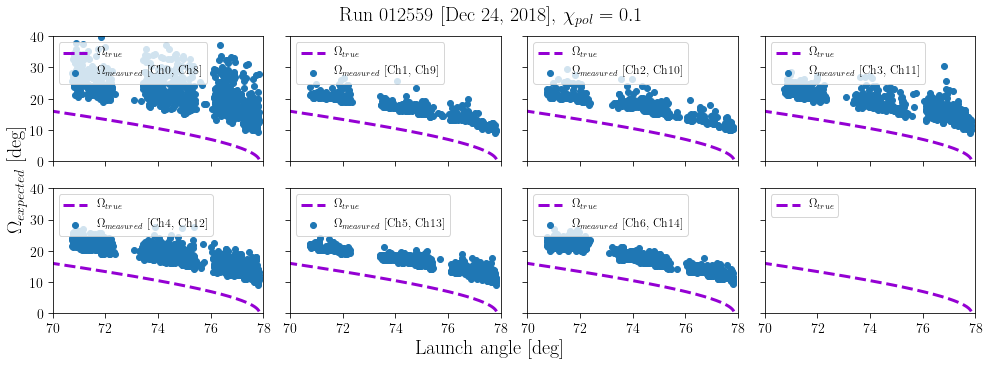

In [174]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()
axs[0].scatter(SpiceCore0ForInterp_limited.launchAng, SpiceCore0ForInterp_limited.Omega_reco2, label = "$\Omega_{measured}$ [Ch0, Ch8]")
axs[1].scatter(SpiceCore1ForInterp_limited.launchAng, SpiceCore1ForInterp_limited.Omega_reco2, label = "$\Omega_{measured}$ [Ch1, Ch9]")
axs[2].scatter(SpiceCore2ForInterp_limited.launchAng, SpiceCore2ForInterp_limited.Omega_reco2, label = "$\Omega_{measured}$ [Ch2, Ch10]")
axs[3].scatter(SpiceCore3ForInterp_limited.launchAng, SpiceCore3ForInterp_limited.Omega_reco2, label = "$\Omega_{measured}$ [Ch3, Ch11]")
axs[4].scatter(SpiceCore4ForInterp_limited.launchAng, SpiceCore4ForInterp_limited.Omega_reco2, label = "$\Omega_{measured}$ [Ch4, Ch12]")
axs[5].scatter(SpiceCore5ForInterp_limited.launchAng, SpiceCore5ForInterp_limited.Omega_reco2, label = "$\Omega_{measured}$ [Ch5, Ch13]")
axs[6].scatter(SpiceCore6ForInterp_limited.launchAng, SpiceCore6ForInterp_limited.Omega_reco2, label = "$\Omega_{measured}$ [Ch6, Ch14]")

# axs[6].set_xlabel("unixTime")
fig.text(0.5, 0.03, 'Launch angle [deg]', ha='center', va='center', fontsize=20)
fig.text(0.03, 0.5, '$\Omega_{expected}$ [deg]', ha='center', va='center', rotation='vertical', fontsize=20)

for ax in axs:
#     ax.set_xlabel("a")
    ax.set_xlim(70,78)
    ax.set_ylim(0,40)
    ax.set(xlabel="", ylabel = "")
    ax.plot(launchAng,pol,"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")


    ax.legend(loc="upper left")

plt.suptitle("Run 012559 [Dec 24, 2018], $\chi_{pol} = %0.1f$"%X_pol, fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
# plt.savefig(my_path_plots+'/SpiceCorePolReco/NewSpiceCoreScatter_run012559_%0.1f.png'%X_pol, dpi=250)


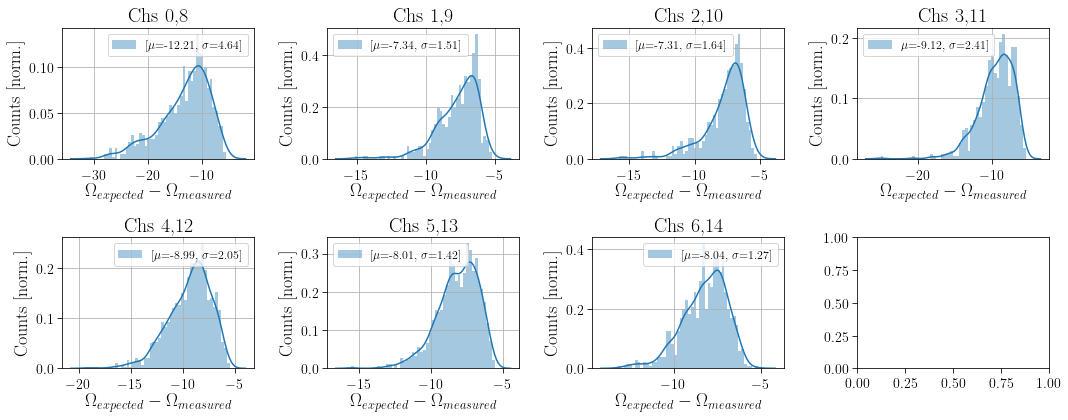

In [163]:
fig, ax = plt.subplots(2, 4, figsize=(15,6))
axs = ax.ravel()
delta = SpiceCore0ForInterp_limited.Omega_true-SpiceCore0ForInterp_limited.Omega_reco2
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[0]);
axs[0].set_xlabel("$\\Omega_{expected}-\\Omega_{measured}$")
axs[0].set_ylabel("Counts [norm.]")
axs[0].legend()
axs[0].grid()
axs[0].title.set_text("Chs 0,8")
# plt.title("$\Delta\Omega$ for SpiceCore events using a single channel pair")

delta = SpiceCore1ForInterp_limited.Omega_true-SpiceCore1ForInterp_limited.Omega_reco2
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[1]);
axs[1].set_xlabel("$\\Omega_{expected}-\\Omega_{measured}$")
axs[1].set_ylabel("Counts [norm.]")
axs[1].legend()
axs[1].grid()
axs[1].title.set_text("Chs 1,9")

delta = SpiceCore2ForInterp_limited.Omega_true-SpiceCore2ForInterp_limited.Omega_reco2
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[2]);
axs[2].set_xlabel("$\\Omega_{expected}-\\Omega_{measured}$")
axs[2].set_ylabel("Counts [norm.]")
axs[2].legend()
axs[2].grid()
axs[2].title.set_text("Chs 2,10")

delta = SpiceCore3ForInterp_limited.Omega_true-SpiceCore3ForInterp_limited.Omega_reco2
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[3]);
axs[3].set_xlabel("$\\Omega_{expected}-\\Omega_{measured}$")
axs[3].set_ylabel("Counts [norm.]")
axs[3].legend()
axs[3].grid()
axs[3].title.set_text("Chs 3,11")

delta = SpiceCore4ForInterp_limited.Omega_true-SpiceCore4ForInterp_limited.Omega_reco2
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[4]);
axs[4].set_xlabel("$\\Omega_{expected}-\\Omega_{measured}$")
axs[4].set_ylabel("Counts [norm.]")
axs[4].legend()
axs[4].grid()
axs[4].title.set_text("Chs 4,12")

delta = SpiceCore5ForInterp_limited.Omega_true-SpiceCore5ForInterp_limited.Omega_reco2
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[5]);
axs[5].set_xlabel("$\\Omega_{expected}-\\Omega_{measured}$")
axs[5].set_ylabel("Counts [norm.]")
axs[5].legend()
axs[5].grid()
axs[5].title.set_text("Chs 5,13")

delta = SpiceCore6ForInterp_limited.Omega_true-SpiceCore6ForInterp_limited.Omega_reco2
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[6]);
axs[6].set_xlabel("$\\Omega_{expected}-\\Omega_{measured}$")
axs[6].set_ylabel("Counts [norm.]")
axs[6].legend()
axs[6].grid()
axs[6].title.set_text("Chs 6,14")

plt.tight_layout()
# plt.savefig(my_path_plots+'/SpiceCorePolReco/deltaDist_run012559.png', dpi=250)

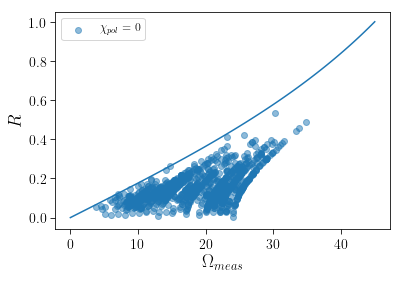

In [62]:
plt.scatter(SpiceCore3ForInterp.Omega_reco2, SpiceCore3ForInterp.R, label = "$\chi_{pol} = 0$", alpha = 0.5)
# plt.scatter(SpiceCore3ForInterp.Omega_reco3, SpiceCore3ForInterp.R2, label = "$\chi_{pol} = 0.1$", alpha = 0.5)
plt.plot(omega,R)
plt.xlabel("$\Omega_{meas}$")
plt.ylabel("$R$")
plt.legend()

In [59]:
R = np.linspace(0,1,100)
omega = np.degrees(np.arccos(1/np.sqrt(R**2+1)))

In [72]:
np.degrees(np.arccos(np.sin(np.radians(114.0))))

24.000000000000004

In [55]:
SpiceCore4ForInterp.loc[SpiceCore4ForInterp.interp_depth <600]
# lim = SpiceCore4ForInterp.loc[SpiceCore4ForInterp.EvNum == 19178]

,EvNum,Omega_reco,unixtime,SNR_V,SNR_H,theta_reco,power_V,power_H,powerV_noise,powerH_noise,interp_depth,R,Omega_reco2,R2,Omega_reco3
2869,19178,11.439527,1545619992,28.896819,0.685518,99.0,8.621911e+07,8.811022e+06,2.811483e+06,5.395739e+06,597.500000,0.202353,14.518328,0.082118,10.141822
2871,19198,8.306338,1545619994,26.007318,2.552837,100.0,6.589116e+07,6.740294e+06,2.811483e+06,5.395739e+06,597.083333,0.145997,12.972751,0.031397,10.158797
2872,19206,8.681616,1545619995,14.393840,1.486486,99.0,1.227421e+08,8.191944e+06,2.811483e+06,5.395739e+06,596.875000,0.152693,12.479927,0.037424,9.249626
2874,19222,9.210900,1545619997,20.632646,1.086875,99.0,7.119050e+07,7.193822e+06,2.811483e+06,5.395739e+06,596.458333,0.162160,12.850702,0.045944,9.373512
2884,19281,9.872856,1545620007,17.521199,3.360450,99.0,1.041295e+08,8.464645e+06,2.811483e+06,5.395739e+06,594.375000,0.174040,13.329242,0.056636,9.561430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3802,27084,3.386374,1545621173,45.444563,1.543160,92.0,6.225040e+08,7.565505e+06,2.811483e+06,5.395739e+06,351.458333,0.059172,3.932285,-0.046745,3.340641
3807,27245,3.191481,1545621195,46.146699,2.293099,92.0,3.463557e+08,6.463861e+06,2.811483e+06,5.395739e+06,346.875000,0.055760,3.765821,-0.049816,3.482830
3809,27275,2.642272,1545621199,43.586949,1.427940,92.0,4.905032e+08,6.434393e+06,2.811483e+06,5.395739e+06,346.041667,0.046149,3.313422,-0.058466,3.897617
3817,27400,1.310304,1545621218,46.885978,3.518078,90.0,3.379040e+08,5.571052e+06,2.811483e+06,5.395739e+06,342.083333,0.022873,1.310304,-0.079414,4.540570


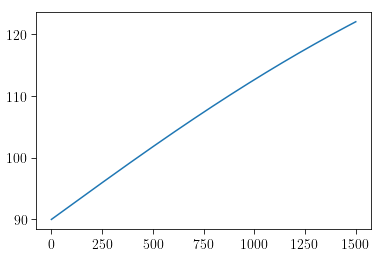

In [32]:
depth = np.linspace(0,1500,1500)
theta = np.degrees(np.arctan(depth/2400))
plt.plot(depth, theta+90)

Text(0,0.5,'$\\theta$')

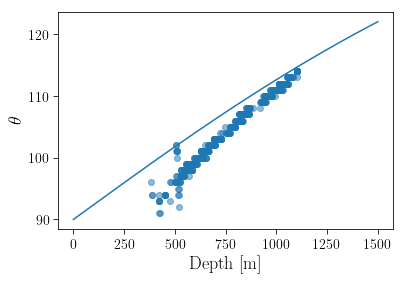

In [86]:
plt.scatter(SpiceCore3ForInterp.interp_depth,SpiceCore3ForInterp.theta_reco, alpha = 0.5)
plt.plot(depth, theta+90)
plt.xlabel("Depth [m]")
plt.ylabel("$\\theta$")

In [69]:
np.sqrt((lim.power_H-lim.powerH_noise)/(lim.power_V-lim.powerV_noise))
print(np.degrees(np.arccos(np.sin(np.radians(lim.theta_reco))/np.sqrt(1+(0.)**2))))

2869    9.0
Name: theta_reco, dtype: float64


In [40]:
lim.im.R

2869    99.0
Name: theta_reco, dtype: float64

In [53]:
lim.R

2869    0.202353
Name: R, dtype: float64